In [1]:
#!pip install qiskit==0.19
# https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from scipy.optimize import minimize
import numpy as np

backend = Aer.get_backend("qasm_simulator")


/opt/conda/lib/python3.8/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/opt/conda/lib/python3.8/site-packages/qiskit/quantum_info/operators/pauli.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zeros(len(label), dtype=np.bool)
/opt/conda/lib/python3.8

In [3]:
def stateprep_node(gammas, betas, p = 1):
    q = QuantumRegister(n)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)
    
    for i in range(n):
        circuit.h(q[i])
    
    circuit.barrier()
    
    for i in range(p):
        gamma = gammas[i]
        beta = betas[i]
        
        for node in nodes:
            theta = node[1]*(node[1]-2*L)*gamma
            circuit.u1(theta, q[node[0]])
            #circuit.p(theta, q[node[0]])
        
        circuit.barrier()
        
        for edge in edges:
            theta = edge[2]*gamma
            node1 = edge[0]
            node2 = edge[1]
            circuit.cu1(theta, q[node1], q[node2])
            #circuit.cu(theta, q[node1], q[node2])
        
        circuit.barrier()
        
        for node in nodes:
            circuit.rx(2*beta, q[node[0]])
        
        circuit.barrier()
        
    return circuit

In [4]:
def stateprep_edge(gammas, betas, p = 1):
    q = QuantumRegister(n)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    
    for i in range(n):
        circuit.h(q[i])
        
    circuit.barrier()
    
    for i in range(p):
        gamma = gammas[i]
        beta = betas[i]
        
        for node in nodes:
            theta = node[1]*(node[1]-2*L)*gamma
            circuit.u1(theta, q[node[0]])
            #circuit.p(theta, q[node[0]])
            
        circuit.barrier()
            
        for edge in edges:
            theta = edge[2]*gamma
            node1 = edge[0]
            node2 = edge[1]
            circuit.cu1(theta, q[node1], q[node2])
            #circuit.cu(theta, q[node1], q[node2])
            
        circuit.barrier()
            
        for node in nodes:
            circuit.rx(2*beta, q[node[0]])
            
        circuit.barrier()
            
    return circuit

In [5]:
def get_node_cost(gammas, betas, p, node):
    circuit = stateprep_node(gammas, betas, p)
    q = circuit.qubits
    c = circuit.clbits
    cost = 0
    weight = node[1]*(node[1]-2*L)/2
    cost += weight
    
    circuit.measure(q[node[0]], c)
    shots = 1000
    job = execute(circuit, backend, shots = shots)
    result = job.result()
    counts = result.get_counts()
    
    try:
        a_2 = counts["0"]
    except:
        a_2 = 0
    try:
        b_2 = counts["1"]
    except:
        b_2 = 0
        
    expval = (a_2 - b_2)/shots
    
    cost += -1*weight*expval
    
    return cost

In [6]:
def get_edge_cost(gammas, betas, p, edge):
    circuit = stateprep_edge(gammas, betas, p)
    q = circuit.qubits
    c = circuit.clbits
    cost = 0
    weight = edge[2]/4
    cost += weight
    circuit.measure(q[edge[0]], c[0])
    circuit.measure(q[edge[1]], c[1])
    shots = 1000
    job = execute(circuit, backend, shots = shots)
    result = job.result()
    counts = result.get_counts()
    
    try:
        a_2 = counts["00"]
    except:
        a_2 = 0
    try:
        b_2 = counts["01"]
    except:
        b_2 = 0
    try:
        c_2 = counts["10"]
    except:
        c_2 = 0
    try:
        d_2 = counts["11"]
    except:
        d_2 = 0
        
    expval = (- a_2 - b_2 - c_2 + 3*d_2)/shots
    
    cost += weight*expval
    
    return cost

In [7]:
def qaoa(beta_gamma):
    betas = beta_gamma[:l]
    gammas = beta_gamma[l:]
    
    optimizer_cost = 0
    
    for node in nodes:
        optimizer_cost += get_node_cost(gammas, betas, p, node)
    
    for edge in edges:
        optimizer_cost += get_edge_cost(gammas, betas, p, edge)
    
    optimizer_cost += L**2

    return optimizer_cost

In [8]:
def finalcircuit(gammas, betas, p = 1):
    q = QuantumRegister(n)
    c = ClassicalRegister(n)
    circuit = QuantumCircuit(q, c)
    
    for i in range(n):
        circuit.h(q[i])
    
    circuit.barrier()
    
    for i in range(p):
        gamma = gammas[i]
        beta = betas[i]
        
        for node in nodes:
            theta = node[1]*(node[1]-2*L)*gamma
            circuit.u1(theta, q[node[0]])
            #circuit.p(theta, q[node[0]])
            
        circuit.barrier()
            
        for edge in edges:
            theta = edge[2]*gamma
            node1 = edge[0]
            node2 = edge[1]
            #circuit.cu(theta, q[node1], q[node2])
            circuit.cu1(theta, q[node1], q[node2])
            
        circuit.barrier()
        
        for node in nodes:
            circuit.rx(2*beta, q[node[0]])
            
        circuit.barrier()
            
    return circuit

In [9]:
p = 10
L = 0
nodes = [(0, -3), (1, 8), (2, -5), (3, 0), (4, -16), (5, 8), (6, 4)]
n = len(nodes)
edges = []
for i in range(n):
    for j in range(i+1, n):
        weight = 2*nodes[i][1]*nodes[j][1]
        edges.append((i,j,weight))
beta = np.random.uniform(0, np.pi*2, p)
gamma = np.random.uniform(0, np.pi*2, p)
beta_gamma = np.concatenate([beta, gamma])
print("beta_gamma:" ,beta_gamma)
l = len(beta_gamma)//2

result = minimize(qaoa, beta_gamma, method="Cobyla")
result

beta_gamma: [2.55564209 3.81997548 3.99021573 1.67477852 4.04805419 0.11749663
 1.94906638 3.80700369 0.69831479 0.91596989 5.45354319 3.24884433
 2.57050284 6.1942979  3.80514433 1.23006882 4.80534277 1.0342718
 4.22599986 2.26212902]


     fun: 86.70999999999995
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 166
  status: 1
 success: True
       x: array([3.80611113, 4.8150328 , 3.74042211, 1.69405502, 4.04919445,
       0.11722883, 1.9494285 , 3.80488541, 1.69902215, 0.91700079,
       5.45391318, 3.24862622, 3.57006222, 6.19371482, 3.80538158,
       1.22945219, 4.80556754, 1.03381374, 4.22599605, 2.26203038])

In [10]:
final_gammas = result.x[l:]
final_betas = result.x[:l]
final_circuit = finalcircuit(final_gammas, final_betas, p)
q_final = final_circuit.qubits
c_final = final_circuit.clbits
final_circuit.measure(q_final, c_final)
#final_circuit.draw(output="mpl")

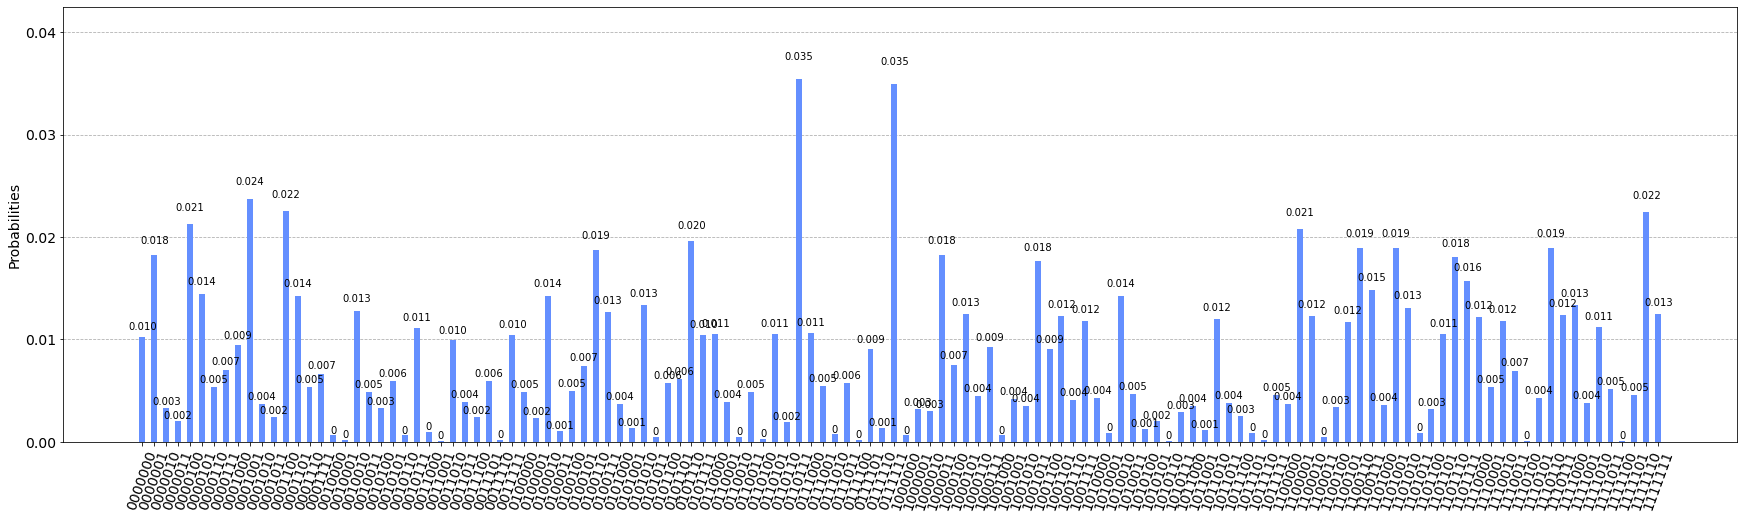

In [11]:
shots = 10000
job = execute(final_circuit, backend, shots=shots)
plot_histogram(job.result().get_counts(final_circuit), figsize=(30, 8))

In [13]:
p = 0.035
print(nodes)
keys = [i for i in list(job.result().get_counts(final_circuit).keys())]
values = [i/2000 for i in list(job.result().get_counts(final_circuit).values())]
k = values.index(p)
keys[k]

[(0, -3), (1, 8), (2, -5), (3, 0), (4, -16), (5, 8), (6, 4)]


'0000111'

In [14]:
job.result().get_counts(final_circuit)

{'0111111': 349,
 '0100000': 48,
 '0110110': 19,
 '1111001': 38,
 '0111001': 54,
 '0000100': 213,
 '1001011': 176,
 '0100101': 74,
 '1011000': 35,
 '0110000': 105,
 '1000100': 75,
 '1100000': 37,
 '1101101': 105,
 '1101010': 131,
 '1100111': 148,
 '0110011': 48,
 '1101100': 32,
 '1100001': 208,
 '1001001': 42,
 '0100100': 49,
 '0101011': 5,
 '0001010': 37,
 '0010000': 6,
 '1101000': 36,
 '1000011': 182,
 '0101000': 37,
 '0011111': 104,
 '0111101': 90,
 '1101001': 189,
 '1110001': 53,
 '1011011': 38,
 '0011000': 9,
 '0011100': 24,
 '0110001': 39,
 '1010111': 29,
 '0010001': 2,
 '1011001': 11,
 '0000111': 70,
 '0011001': 1,
 '0110111': 354,
 '0000110': 53,
 '1101110': 180,
 '1110111': 124,
 '0010100': 33,
 '1010101': 20,
 '0101100': 57,
 '1010011': 47,
 '1000101': 125,
 '0110010': 5,
 '1001101': 123,
 '1001010': 35,
 '0000010': 33,
 '1000110': 45,
 '1000010': 30,
 '0001110': 53,
 '1011111': 46,
 '0010101': 59,
 '0011101': 59,
 '1111010': 112,
 '0111100': 2,
 '0111110': 13,
 '1110010': 11